In [17]:
import xml.etree.ElementTree as ET
from glob import glob
import os
import pandas as pd
import torchvision
from PIL import Image
from torchsummary import summary
from torchvision import transforms
import torch
from sklearn import svm
from PIL import Image
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
tqdm.pandas()

In [1]:
!pip list

Package                       Version
----------------------------- ----------------------------
absl-py                       1.2.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.8

In [18]:
import torchvision.transforms.functional as tvf
import numpy as np
class ResizedRotation():
    def __init__(self, angle, output_size=(96, 96)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img

In [19]:
class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)

In [20]:
cifar10_unlabeled = CIFAR10("./dataset", download=True)

Files already downloaded and verified


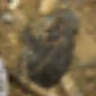

In [21]:
random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle), [(0.0, 360.0)])
random_resized_rotation(tvf.resize(cifar10_unlabeled[23][0], (96, 96)))

In [22]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
import random
def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image
    
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, target_size=(96, 96), debug=False):
        super().__init__()
        self.ds = ds
        self.debug = debug
        self.target_size = target_size
        if debug:
            print("DATASET IN DEBUG MODE")
        
        # I will be using network pre-trained on ImageNet first, which uses this normalization.
        # Remove this, if you're training from scratch or apply different transformations accordingly
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        self.randomize = transforms.Compose([
            transforms.RandomResizedCrop(target_size, scale=(1/3, 1.0), ratio=(0.3, 2.0)),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(random_rotate)
            ]),
            transforms.RandomApply([
                random_resized_rotation
            ], p=0.33),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2)
        ])
    
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw, _ = self.ds[idx]
        
        if self.debug:
            random.seed(idx)
            t1 = self.randomize(this_image_raw)
            random.seed(idx + 1)
            t2 = self.randomize(this_image_raw)
        else:
            t1 = self.randomize(this_image_raw)
            t2 = self.randomize(this_image_raw)
        
        if preprocess:
            t1 = self.preprocess(t1)
            t2 = self.preprocess(t2)
        else:
            t1 = transforms.ToTensor()(t1)
            t2 = transforms.ToTensor()(t2)

        return (t1, t2), torch.tensor(0)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

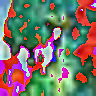

In [23]:
ds = PretrainingDatasetWrapper(cifar10_unlabeled, debug=False)
tvf.to_pil_image(ds[10][0][0])

In [24]:
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = torchvision.models.resnet18(weights='IMAGENET1K_V1') 
        internal_embedding_size = base_model.fc.in_features
        base_model.fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection

In [25]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

In [26]:
from torch.multiprocessing import cpu_count
from torch.optim import RMSprop
from argparse import Namespace

class ImageEmbeddingModule(pl.LightningModule):
    def __init__(self, hparams):
        # hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        super().__init__()
        self.save_hyperparameters(hparams)
        # self.hparams = hparams
        self.model = ImageEmbedding()
        self.loss = ContrastiveLoss(self.hparams.batch_size)
    
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs
    
    def train_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(cifar10_unlabeled, 
                                             debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size, 
                          num_workers=cpu_count(),
                          sampler=SubsetRandomSampler(list(range(hparams.train_size))),
                         drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(cifar10_unlabeled,
                                            debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size, 
                          shuffle=False,
                          num_workers=cpu_count(),
                          sampler=SequentialSampler(list(range(hparams.train_size + 1, hparams.train_size + hparams.validation_size))),
                         drop_last=True)
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        (X, Y), y = batch
        embX, projectionX = self.forward(X)
        embY, projectionY = self.forward(Y)
        loss = self.loss(projectionX, projectionY)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        "progress_bar": {loss_key: loss}}
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        return [optimizer], []

In [27]:
from argparse import Namespace
hparams = Namespace(
    # lr=0.000630957344480193,
    lr=0.0005,
    epochs=15,
    batch_size=160,
    train_size=20000,
    validation_size=1000
)
# module = ImageEmbeddingModule(hparams)
# # logger = WandbLogger(project="simclr-blogpost")
# # logger.watch(module, log="all", log_freq=50)
trainer = pl.Trainer(gpus=1,max_epochs=hparams.epochs)
# trainer.fit(module)
# checkpoint_file = "resnet-b0-cifar-embeddings.ckpt"
# trainer.save_checkpoint(checkpoint_file)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [28]:
import torchvision.transforms as T
cifa100_data = CIFAR100(root="./dataset", download=True,
                       transform=T.Compose([
    T.Resize(size=224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

)

Files already downloaded and verified


In [30]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.datasets import CIFAR100

class SimCLRClassifier(nn.Module):
    def __init__(self, n_classes, freeze_base, embeddings_model_path, hidden_size=512):
        super().__init__()
        
        base_model = ImageEmbeddingModule.load_from_checkpoint(embeddings_model_path).model
        
        self.embeddings = base_model.embedding
        
        if freeze_base:
            print("Freezing embeddings")
            for param in self.embeddings.parameters():
                param.requires_grad = False
                
        # Only linear projection on top of the embeddings should be enough
        self.classifier = nn.Linear(in_features=base_model.projection[0].in_features, 
                      out_features=n_classes if n_classes > 2 else 1)

    
    def forward(self, X, *args):
        emb = self.embeddings(X)
        return self.classifier(emb)

class SimCLRClassifierModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.model = SimCLRClassifier(hparams.n_classes, hparams.freeze_base, 
                                      hparams.embeddings_path,
                                      self.hparams.hidden_size)
        self.loss = nn.CrossEntropyLoss()
    
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs
    
    def preprocessing(self):
        return transforms.Compose([
                transforms.Resize(size=224),
                transforms.ToTensor,
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def get_dataloader(self, split):
        return DataLoader(cifa100_data,
                          batch_size=self.hparams.batch_size, 
                          shuffle=split=="train",
                          num_workers=cpu_count(),
                         drop_last=False)
    
    def train_dataloader(self):
        return self.get_dataloader("train")
    
    def val_dataloader(self):
        return self.get_dataloader("test")
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        X, y = batch
        y_out = self.forward(X)
        loss = self.loss(y_out, y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        "progress_bar": {loss_key: loss}}
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        return self.step(Batch, "test")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        schedulers = [
            CosineAnnealingLR(optimizer, self.hparams.epochs)
        ] if self.hparams.epochs > 1 else []
        return [optimizer], schedulers

In [35]:
hparams_cls = Namespace(
    lr=0.000251,
    epochs=5,
    batch_size=160,
    n_classes=100,
    freeze_base=True,
    embeddings_path="./resnet-b0-cifar-embeddings.ckpt",
    hidden_size=512
)
# module = SimCLRClassifierModule(hparams_cls)
# # logger = WandbLogger(project="simclr-blogpost-classifier")
# # logger.watch(module, log="all", log_freq=10)
trainer2 = pl.Trainer(gpus=1, max_epochs=hparams_cls.epochs)
# lr_find_cls = trainer.tuner.lr_find(module)
# lr_find_cls.suggestion()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [36]:

module2 = SimCLRClassifierModule(hparams_cls)
trainer2.fit(module2)
checkpoint_file = "cifar100-classifer.ckpt"
trainer2.save_checkpoint(checkpoint_file)


Freezing embeddings


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | SimCLRClassifier | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
51.3 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.911    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
from sklearn.metrics import classification_report
def evaluate(data_loader, module):
    with torch.no_grad():
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        module2.eval().cuda()
        true_y, pred_y = [], []
        for i, batch_ in enumerate(data_loader):
            X, y = batch_
            print(progress[i % len(progress)], end="\r")
            y_pred = torch.argmax(module(X.cuda()), dim=1)
            true_y.extend(y.cpu())
            pred_y.extend(y_pred.cpu())
        print(classification_report(true_y, pred_y, digits=3))
        return true_y, pred_y
_ = evaluate(module2.val_dataloader(), module)